# Flow Matching

In this notebook, we will show how to use flow matching for our airfoil flow problem. You can run this note book directly in [colab](https://colab.research.google.com/github/tum-pbs/Diffusion-based-Flow-Prediction/blob/main/flow_matching.ipynb).

Flow matching is another generative model that has become popular recently. Similarly to diffusion models, it also starts with a Gaussian distribution and gradually transforms it into the target distribution but provides a much faster inference speed. We will not get deeper into the theory behind flow matching. If you are interested, you can refer to the following materials:

* [Flow Matching for Generative Modeling](https://arxiv.org/abs/2210.02747)
* [An Introduction to Flow Matching](https://mlg.eng.cam.ac.uk/blog/2024/01/20/flow-matching.html)

Similar to previous note, we need to prepare the dataset for sampling. If you are not familiar with the data structure and the `DataFiles` class we used to organize the dataset, please refer to [generate_dataset.ipynb](https://github.com/tum-pbs/Diffusion-based-Flow-Prediction/blob/main/generate_dataset.ipynb) and [process_dataset.ipynb](https://github.com/tum-pbs/Diffusion-based-Flow-Prediction/blob/main/process_dataset.ipynb)

In [ ]:
# run this cell to install the required packages and clone the repository if you are using colab
%pip install einops bayesian_torch
!git clone https://github.com/tum-pbs/Diffusion-based-Flow-Prediction.git
%cd Diffusion-based-Flow-Prediction/

In [10]:
import zipfile
from airfoil_diffusion.airfoil_datasets import *
from airfoil_diffusion.networks import *
from airfoil_diffusion.trainer import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not os.path.exists("./datasets/1_parameter/data/"):
    files=[file for file in os.listdir("./datasets/1_parameter/") if file.endswith(".zip")]
    for file in tqdm(files): 
        f=zipfile.ZipFile("./datasets/1_parameter/"+file,'r')
        for file in f.namelist():
            f.extract(file,"./datasets/1_parameter/data/")
        f.close() 

df_train=FileDataFiles("./datasets/1_parameter/train_cases.txt",base_path="./datasets/1_parameter/data/")
train_dataset = AirfoilDataset(df_train,data_size=32)

network = AifNet("./pre_trained/single_parameter/32/diffusion/network_configs.yaml")

Loading data: 100%|██████████| 125/125 [00:00<00:00, 389.07it/s]


Then, we can define a trainer for flow matching. We can set up a flow matching trainer similar to previous [diffusion training](https://github.com/tum-pbs/Diffusion-based-Flow-Prediction/blob/main/train_networks.ipynb). All the detailed code for flow matching is implemented in the `airfoil_diffusion.flowmatching` sub-module. You can look deeper into the code to see what exactly happens in the loss function.

In [ ]:
from airfoil_diffusion.flowmatching import OTCondFlowMatcher

class FMatchingTrainer(TrainerStepLr):
    
    def __init__(self) -> None:
        super().__init__()
    
    def event_before_training(self,network):
        self.flow_matcher = OTCondFlowMatcher()
        
    def train_step(self, network: torch.nn.Module, batched_data, idx_batch: int, num_batches: int, idx_epoch: int, num_epoch: int):
        condition = batched_data[0].to(device=self.configs.device)
        targets = batched_data[1].to(device=self.configs.device)
        loss=self.flow_matcher.cfm_loss(network=network,x_1=targets,condition=condition)
        return loss

fmatching_trainer=FMatchingTrainer()
fmatching_trainer.train_from_scratch(name="flowmatching",
                                     network=network,
                                     train_dataset=train_dataset,
                                     path_config_file="./pre_trained/train_configs.yaml",
                                     save_path="./training/single_parameter/32/",)

Now, we can start to evaluate the trained model! We first need to post-process the test dataset to get some ground truth results for comparison. This procedure is the same as the previous [sample.ipynb](https://github.com/tum-pbs/Diffusion-based-Flow-Prediction/blob/main/sample.ipynb)

In [13]:
df_test=FileDataFiles("./datasets/1_parameter/test_cases.txt",base_path="./datasets/1_parameter/data/")
df_test.sort()
std_field_test_gd=[]
mean_field_test_gd=[]
inputs_test=[]
samples_gd=[]
for case in df_test.get_simulation_cases():
    datas=[]
    selected_cases=df_test.select_simulation_cases([case])
    for case in selected_cases:
        raw_data=read_single_file(case['path']+case['file_name'],model="dimless",scale_factor=0.25)
        datas.append(
            raw_data[3:]
            )
    inputs_test.append(read_single_file(case['path']+case['file_name'],model="normalized",scale_factor=0.25)[0:3])
    samples_gd.append(np.stack(datas,axis=0))
    std_field_test_gd.append(samples_gd[-1].std(axis=0))   
    mean_field_test_gd.append(samples_gd[-1].mean(axis=0))
std_field_test_gd=np.stack(std_field_test_gd,axis=0)
mean_field_test_gd=np.stack(mean_field_test_gd,axis=0)

df_all=DataFiles(df_train.case_list+df_test.case_list)
df_all.sort()
std_value_gd=[]
for case in df_all.get_simulation_cases():
    datas=[]
    selected_cases=df_all.select_simulation_cases([case])
    for case in selected_cases:
        datas.append(
            read_single_file(case['path']+case['file_name'],model="dimless",scale_factor=0.25)[3:] # scale factor is 0.25 to geet 32 $\times$ 32 data
            )
    std_value_gd.append(np.stack(datas,axis=0).std(axis=0).mean())

CHANNEL_NAME_MEAN=[r"$\mu_p^*$",r"$\mu_{u_x^*}$",r"$\mu_{u_y^*}$"]
CHANNEL_NAME_STD=[r"$\sigma_{p^*}$",r"$\sigma_{u_x^*}$",r"$\sigma_{u_y^*}$"]

Now, we can design a sample function for flow matching. Compared to the previous diffusion sample function (also see below), we just replace the `diffuser.sample_from_noise` function to `flow_matcher.sample` function.

In [ ]:
from airfoil_diffusion.flowmatching.odesolve import FixedStepConfig,AdaptiveStepConfig,ODESolver

def sample_flowmatching(network,input_field,solver_config,num_sample=100):
    network.eval();network.to(device);predictions=[]
    batch_size=25;N_all=num_sample
    flow_matcher=OTCondFlowMatcher()
    while N_all>0:
        batch_size_now=min(batch_size,N_all)
        N_all-=batch_size
        condition=input_field.to(device).repeat(batch_size_now,1,1,1)
        noise=torch.randn_like(condition)
        prediction_batch=normalized2dimless(
            flow_matcher.sample(x_0=noise,
                            network=network,
                            solver_config=solver_config,
                            condition=condition)
            )
        predictions.append(prediction_batch.detach().cpu().numpy())
    predictions=np.concatenate(predictions,axis=0)
    return np.mean(predictions,axis=0),np.std(predictions,axis=0),predictions

Different from diffusion models, the inference procedure of flow matching is a process of solving first-order Ordinary differential equations (ODEs) as

$$
x_1 = x_0+\int_0^1 v_\theta(x,t) dt
$$

where the neural network works as the derivative terms $v_\theta(x,t)$, $x_0$ is the initial distribution, i.e., Gaussian distribution in our case, and $x_1$ is the target distribution. You can use several different ODE solvers to solve this equation. In our code, we provide the following solvers:

In [17]:
for solver in ODESolver:
    print("{}, adaptive step support: {}".format(solver.name,solver.value["adaptive"]))

EULER, adaptive step support: False
MIDPOINT, adaptive step support: False
HEUN12, adaptive step support: True
RALSTON12, adaptive step support: True
BOGACKI_SHAMPINE23, adaptive step support: True
RK4, adaptive step support: False
RK4_38RULE, adaptive step support: False
DOPRI45, adaptive step support: True
FEHLBERG45, adaptive step support: True
CASHKARP45, adaptive step support: True


You can specify the `solver_config` parameter to use different solver:
*  `airfoil_diffusion.flowmatching.odesolve.FixedStepConfig`: use fixed step ode solver
*  `airfoil_diffusion.flowmatching.odesolve.AdaptiveStepConfig`: use adaptive ode solver
Another simple way to switch between fixed step solver and adaptive step solver is to directly use `flow_matcher.fixed_step_sample` and `flow_matcher.adaptive_sample` rather than `flow_matcher.sample` function.

In the following, we will use the simplest Euler solver and change the number of steps to see the difference in the performance. We recommend you try to use a different Ode solver by yourself to see the effect of the solver configuration. Just be aware that a single inference step may contain multiple calls of neural networks if you use a high-order solver like Runge–Kutta-4.

In [5]:
network.load_state_dict(torch.load("./pre_trained/single_parameter/32/flow_matching/weight.pt"))
index=3
input_field=inputs_test[index].unsqueeze(0)

titles=[]
result_fms=[]
for step in tqdm([1,2,5,10,20,50,100,200]):
    solver_config=FixedStepConfig(dt=1/step,solver=ODESolver.EULER)
    mean_fm,std_fm,samples_fm=sample_flowmatching(network,input_field,solver_config=solver_config)
    titles.append("Flow Matching {}".format(step))
    result_fms.append(np.concatenate([mean_fm,std_fm],axis=0))

100%|██████████| 8/8 [00:11<00:00,  1.45s/it]


We can reuse the code in the previous [sample.ipynb](https://github.com/tum-pbs/Diffusion-based-Flow-Prediction/blob/main/sample.ipynb) to generate some samples from the diffusion model for comparison.

In [14]:
def sample_diffusion(network,input_field,num_diffusion_sample=100):
    network.eval();network.to(device);predictions=[]
    batch_size=25;N_all=num_diffusion_sample
    diffuser=Cos2ParamsDiffuser(200,device=device)
    while N_all>0:
        batch_size_now=min(batch_size,N_all)
        N_all-=batch_size
        prediction_batch=normalized2dimless(
            diffuser.sample_from_noise(network,
                                       input_field.to(device).repeat(batch_size_now,1,1,1),
                                       show_progress=False))
        predictions.append(prediction_batch.detach().cpu().numpy())
    predictions=np.concatenate(predictions,axis=0)
    return np.mean(predictions,axis=0),np.std(predictions,axis=0),predictions

dif_network=AifNet("./pre_trained/single_parameter/32/diffusion/network_configs.yaml")
dif_network.load_state_dict(torch.load("./pre_trained/single_parameter/32/diffusion/weights_0.pt"))
mean,std,samples_diffusion=sample_diffusion(dif_network,input_field)
result_diffusion=np.concatenate([mean,std],axis=0)

Let's first do some quantitative comparisons where we plot the mean and standard deviation field of a single test case:

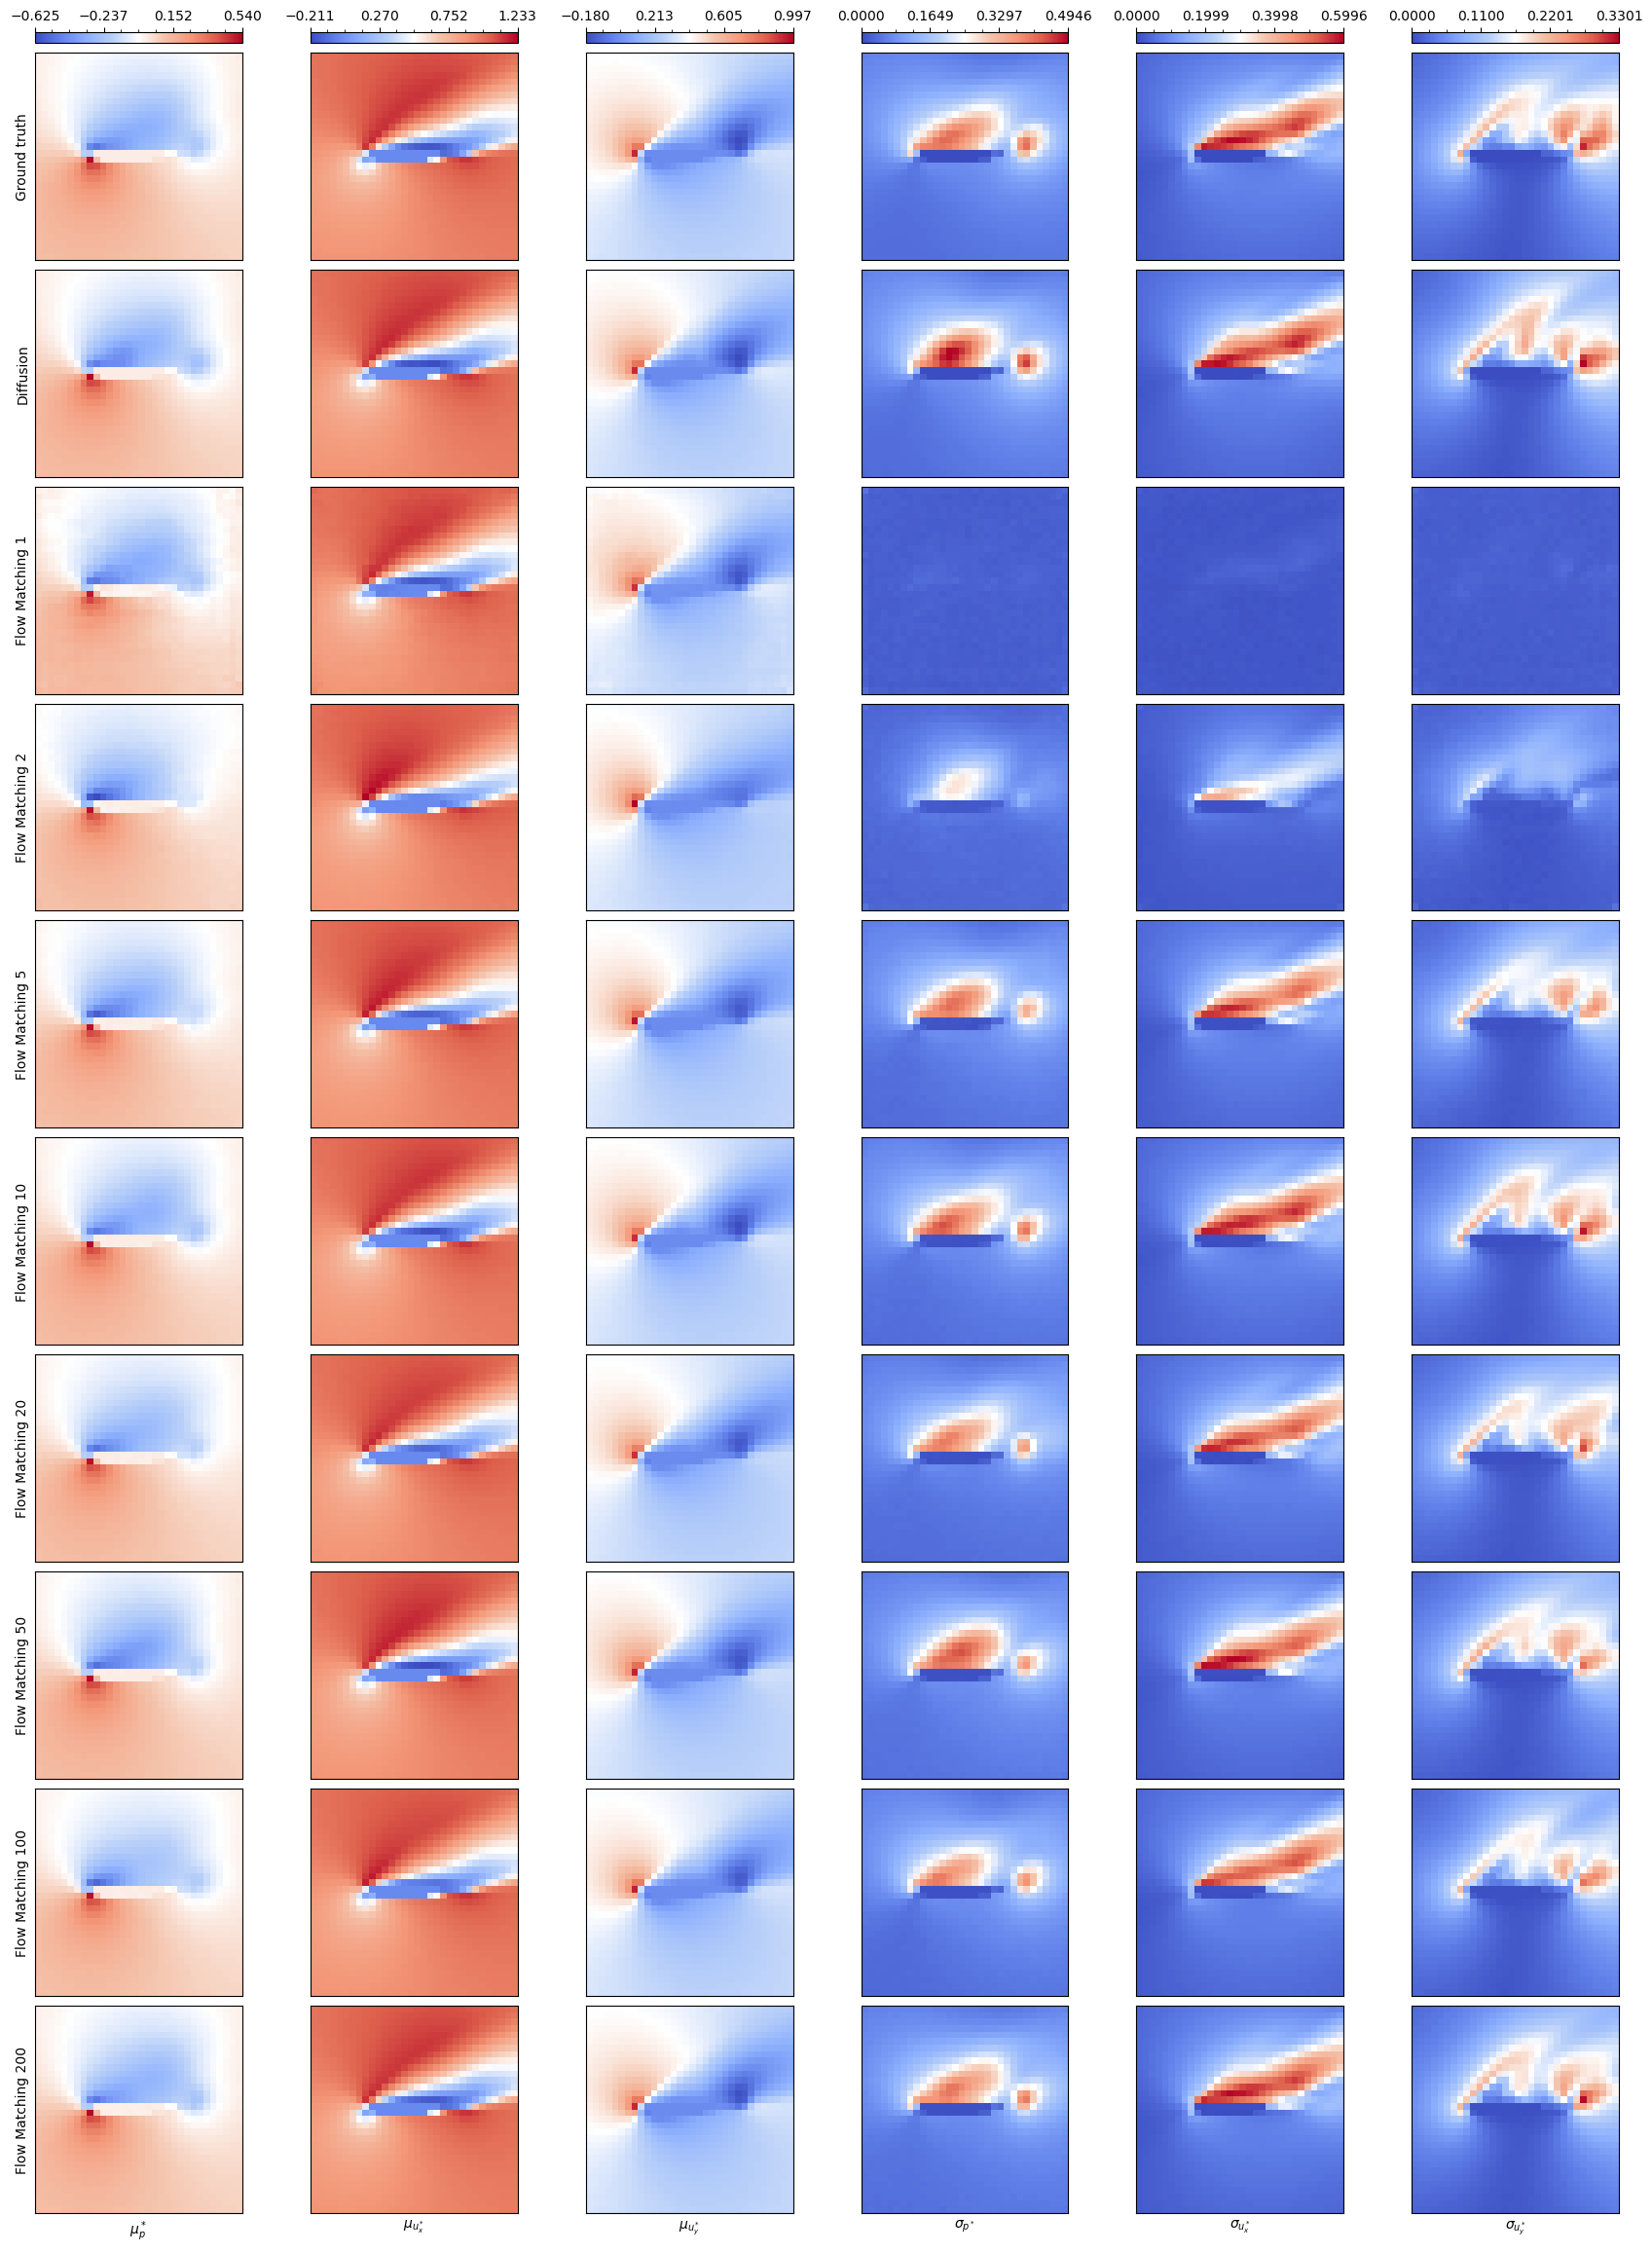

In [6]:
result_ground_truth=np.concatenate([mean_field_test_gd[index],std_field_test_gd[index]],axis=0)

from airfoil_diffusion.plotter import *
show_each_channel([result_ground_truth,result_diffusion]+result_fms,
                  channel_names=CHANNEL_NAME_MEAN+CHANNEL_NAME_STD,
                  case_names=["Ground truth","Diffusion"]+titles,transpose=True,inverse_y=True)

From the qualitative results, flow matching is able to generate a good result when the number of sampling steps is greater than or equal to 5. Then, let's do some more quantitative comparisons with the plot of how the average mean square error changes with Reynolds number:

In [8]:
def do_test(sample_func):
    mean_predictions=[]
    std_predictions=[]
    std_a_predictions=[]
    for input_field in tqdm(inputs_test):
        mean_fields,std_fields,_=sample_func(input_field.unsqueeze(0))
        mean_predictions.append(mean_fields)
        std_predictions.append(std_fields)
        std_a_predictions.append(np.mean(std_fields))
    return mean_predictions,std_predictions,std_a_predictions 

std_a_fms=[]
labels=[]
for step in [1,2,5,10,20,50,100,200]:
    _,_,std_a_fm_i=do_test(lambda x:sample_flowmatching(
                                                    network,
                                                    x,
                                                    solver_config=FixedStepConfig(dt=1/step,
                                                                                  solver=ODESolver.EULER),
                                                    num_sample=500)
                       )
    std_a_fms.append(std_a_fm_i)
    labels.append("Flow Matching {}".format(step))


100%|██████████| 6/6 [02:59<00:00, 29.86s/it]


In [9]:
_,_,std_a_predictions_dif=do_test(lambda x:sample_diffusion(dif_network,x,num_diffusion_sample=500))

100%|██████████| 6/6 [02:53<00:00, 28.89s/it]


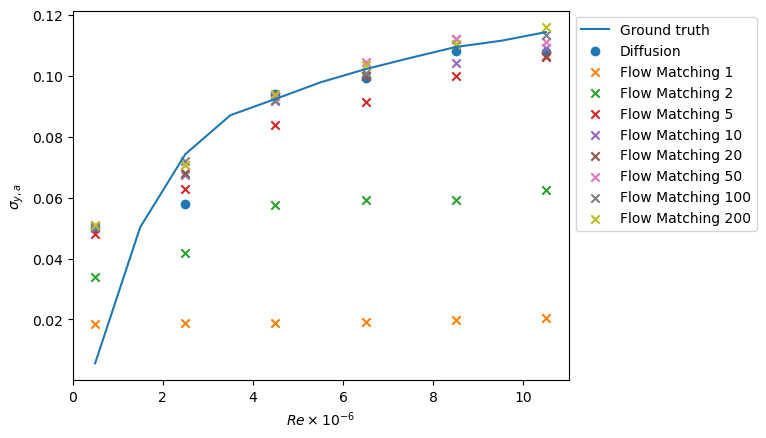

In [12]:
x=[0.5 +2*i for i in range(6)]
plt.plot([0.5 +i for i in range(11)],std_value_gd,label="Ground truth")
plt.scatter(x,std_a_predictions_dif,label="Diffusion",marker="o")
for i in range(len(std_a_fms)):
    plt.scatter(x,std_a_fms[i],label=labels[i],marker="x")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.xlabel(r"$Re \times 10^{-6}$")
plt.ylabel(r"$\sigma_{y,a}$")
plt.show()

The accuracy of flow-matching predictions increases with the increase of sampling steps. Specifically, when the number of steps is equal to 10, the flow matching can already provide better results than diffusion models. Considering that the diffusion models here require 200 steps for sampling, flow matching is definitely a better method to try.